<a href="https://colab.research.google.com/github/poliduckie/MPC/blob/main/dataset_generation/MSCOCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#img_num="5"
train = True

In [5]:
#dataset_name = "real"
dataset_name = "js"

if dataset_name=="js":
    image_folder = "/content/drive/My Drive/DATASET/wo_bezier/rgb_orig/"
    mask_folder = "/content/drive/My Drive/DATASET/wo_bezier/labels/"
    img_num="7"
    ext="png"
    real = False
real

False

In [6]:
import random
r = lambda: random.randint(0,255)

def random_color():
    return (r(),r(),r())
#thresh

In [7]:

#image = cv2.imread(f'{image_folder}/{img_num}.jpg')[:,:,::-1]
f'{image_folder}/{img_num}.{ext}'
js2sim = {0:0, 1:2, 2:1, 3:3, 4:4, 5:5}

In [8]:
import os
os.path.exists(f'{image_folder}/{img_num}.{ext}')

True

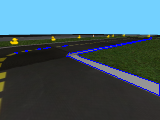

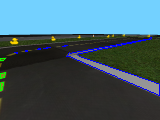

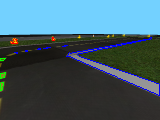

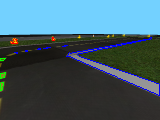

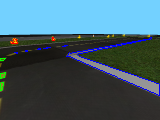

In [9]:
mask_flattened = np.load(f'{mask_folder}/{img_num}.npy')
if dataset_name == "js":
    mask_flattened = cv2.resize(mask_flattened.reshape(240,320).astype(np.uint8), (160,120), cv2.INTER_NEAREST)

h, w = 160, 120
mask_reshaped = mask_flattened.reshape(w,h)
image = cv2.imread(f'{image_folder}/{img_num}.{ext}')
if dataset_name == "js":
    image = cv2.resize(image, (160,120))

from google.colab.patches import cv2_imshow
for i in range(1,6):
    thresh = (mask_reshaped==i).astype(np.uint8)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    #cnt = contours[1]
    if real:
        i = real2sim[i]
    if dataset_name=="js":
        i = js2sim[i]
    if i==1:
        col=(0,255,0) #Yellow Line -> Green
    elif i==2:
        col=(255,0,0) #White Line -> Blue
    else:
        col=(0,0,255) #
    for cnt in contours:
        epsilon = 0.001*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt,True)
        if len(approx>4) and area>1:
            #print(area/perimeter)
            if area/perimeter>0.1:
                pts = np.array(approx, np.int32)
                pts = pts.reshape((-1,1,2))
                image2 = cv2.polylines(image,[pts],True,col)
    cv2_imshow(image2)

In [10]:
image = cv2.imread(f'{image_folder}/{img_num}.{ext}')
#image

LABELS

In [11]:
category_names = ["background", "yellow_line","white_line","obstacles","duckiebot","red_line"]
categories = []
for i, name in enumerate(category_names):
    if i!=0:
        categories.append({"supercategory": name, "id":i, "name": name})

In [12]:
categories

[{'supercategory': 'yellow_line', 'id': 1, 'name': 'yellow_line'},
 {'supercategory': 'white_line', 'id': 2, 'name': 'white_line'},
 {'supercategory': 'obstacles', 'id': 3, 'name': 'obstacles'},
 {'supercategory': 'duckiebot', 'id': 4, 'name': 'duckiebot'},
 {'supercategory': 'red_line', 'id': 5, 'name': 'red_line'}]

In [14]:
import glob
orig_files = glob.glob(f"{image_folder}*.{ext}")
import random
random.shuffle(orig_files)

In [15]:
from tqdm import tqdm
files = orig_files
import os
images = []
basename_to_id = {}
for i, file in enumerate(tqdm(files)):
    basename = os.path.basename(file)
    if dataset_name=="js":
        image = cv2.imread(file)
        image = cv2.resize(image, (160,120))
        #print()
        cv2.imwrite(file.replace(".png",".jpg"), image)
        basename = basename.replace(".png",".jpg")
        
    entry = {"file_name":basename, "height":120, "width":160, "id":i}
    basename_to_id[basename]=entry["id"]
    images.append(entry)
#images

100%|██████████| 31/31 [00:11<00:00,  2.64it/s]


In [16]:
#basename_to_id
ret,thresh = cv2.threshold(image,127,255,0)

In [17]:
thresh.shape

(120, 160, 3)

In [28]:
#from cv2_plt_imshow import cv2_plt_imshow as cv2_imshow
annotation={}
def get_annotations(image_file_name, mask_file_name, annotation_id):
    global annotation, pts
    image_annotations=[]
    mask_flattened = np.load(mask_file_name)
    basename = os.path.basename(image_file_name)
    if dataset_name == "js":
        mask_flattened = cv2.resize(mask_flattened.reshape(240,320).astype(np.uint8), (160,120), cv2.INTER_NEAREST)
        basename= basename.replace(".png",".jpg")
    #print(basename)
    h, w = 160, 120
    mask_reshaped = mask_flattened.reshape(w,h)
    image = cv2.imread(image_file_name)

    for i in range(1,6):
        thresh = (mask_reshaped==i).astype(np.uint8)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        #cnt = contours[1]
        if dataset_name=="js":
            i=js2sim[i]
        if i==1:
            col=(0,255,0)
        elif i==2:
            col=(255,0,0)
        else:
            col=(0,0,255)
        for cnt in contours:
            epsilon = 0.002*cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,epsilon,True)
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt,True)
            if len(approx>4) and area>1:
                #print(area/perimeter)
                if area/perimeter>0.1:
                    pts = np.array(approx, np.int32)
                    pts = pts.reshape((-1,1,2))
                    x, y = pts.reshape(-1,2)[:,0], pts.reshape(-1,2)[:,1]
                    bbox = [float(x.min()), float(y.min()), float(x.max()-x.min()),float(y.max()-y.min())]
                    annotation={"area":area,
                        "iscrowd":0,
                        "image_id": basename_to_id[basename],
                        "segmentation": [pts.flatten().tolist()],
                        "bbox": bbox,
                        "category_id": i,
                        "id":annotation_id
                       }
                    annotation_id+=1
                    image_annotations.append(annotation)
                    #print(annotation)
                    #image2 = cv2.polylines(image,[pts],True,col)
        #cv2_imshow(image2)
        
    #print(annotation_id)
    return image_annotations, annotation_id
#img_num=10205
#img_num="frame25468"
mask_file_name = f'{mask_folder}{img_num}.npy'
image_file_name=  f'{image_folder}{img_num}.{ext}'
annotation_id = 1
image_annotations=get_annotations(image_file_name, mask_file_name, annotation_id)
#image_annotations

In [20]:
image_filename_to_image_map = {}
for image in images:
    image_filename_to_image_map[image["file_name"]] = image

write annotation in /data/duckie_.json file

In [49]:


def get_annorations_and_write(files, suffix="train"):
    annotations=[]
    from tqdm import tqdm
    annotation_id = 1
    good_images = []
    for file in tqdm(files):
        basename = os.path.basename(file)
        #print(basename)
        mask_file_name = f'{mask_folder}{basename.replace(".jpg",".npy").replace(".png",".npy")}'
        image_file_name=  f'{image_folder}{basename}'
        image_annotations, annotation_id =get_annotations(image_file_name, mask_file_name, annotation_id)
        annotations+=image_annotations
        good_images.append(image_filename_to_image_map[basename.replace(".png",".jpg")])
    data={"categories":categories, "images":good_images,"annotations":annotations}
    with open(f"/content/drive/My Drive/DATASET/data/duckie_{dataset_name}_{suffix}.json","w") as f:
        json.dump(data,f)

In [50]:
#get_annorations_and_write(files,"all")
len(files)
import json

In [51]:
get_annorations_and_write(files[0:9500],"train")
get_annorations_and_write(files[9500:],"val")

100%|██████████| 31/31 [00:00<00:00, 103.88it/s]
0it [00:00, ?it/s]
